##  Analizy danych sekwencjonowania w technologii Oxford Nanopore z uwzględnieniem występowania wariantów w pozycjach 3460 (G>A) oraz 9889 (C>T)

Etapy postępowania:
1. Import bibliotek do analizy danych.
2. Przekształcenie danych z sekwencjonowania Nanopore w formatu binarnego bam do sam, pozostawienie tylko linii zawierających odczyty (usunięcie danych z nagłówka pliku sam), wybór tylko 10 pierwszych kolumn (zmniejszenie szerokości tabeli).
3. Wczytanie danych do Pythona z wykorzystaniem biblioteki Pandas.
3. Podział danych ze względu na numer eksperymentu - większość danych pochodzi z 1. eksperymentu. W drugi ksperymencie usyskano tylko 23 odczyty, dlatego w dalszej procedurze nie będziemy ich traktować odrębnie.
3. Identyfikacja nukleotydów, które znajdują się w pozycjach: 3460 oraz 9889.
4. Analiza statytyczna danych.

## Import bibliotek

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re


%matplotlib inline # ta komenta umożliwia wyświetlanie wykresów w tym notatniku

## Przekształcenie danych 
Przekształcenie danych z sekwencjonowania Nanopore w formatu binarnego bam do sam, pozostawienie tylko linii zawierających odczyty (usunięcie danych z nagłówka pliku sam), wybór tylko 10 pierwszych kolumn (zmniejszenie szerokości tabeli)

In [ ]:
## Poniższe polecenia są komendami z terminala. 
## Zastosowanie wykrzyknika na początku linii umożliwia ich implementację w środowisku Jupyter notebook. 

# Przekształcenie danych z formatu binarnego bam do formatu sam
!samtools view -h -o dane_dec2023/rCRS_mtDNA-P2-80-050723-all_selected_range_output.sam dane_dec2023/rCRS_mtDNA-P2-80-050723-all_selected_range_output.bam

# Usunięcie wszystkich linii nagłówkowych z pliku SAM, pozostawiając tylko linie z danymi o mapowaniu sekwencji
!grep -v '^@' dane_dec2023/rCRS_mtDNA-P2-80-050723-all_selected_range_output.sam > dane_dec2023/rCRS_mtDNA_2experiments.sam

# Ekstrakcja pierwszych 10 kolumn, które zawierają dane kluczowe dla dalszej analizy
!cut -f 1-10 dane_dec2023/rCRS_mtDNA_2experiments.sam > dane_dec2023/nanopore_2experiments.sam

## Wczytanie danych do Pythona z wykorzystaniem biblioteki Pandas

In [15]:
# Wczytanie przygotowanej tabeli do Pythona 
sam = pd.read_csv('dane_dec2023/nanopore_2experiments.sam', 
                  sep = '\t', names = ['read_id', 'flag', 'rname', 'pos','mapq', 'cigar', 'RNEXT', 'PNEXT',
                                      'TLEN', 'seq'])
# Usunięcie wybranych kolumn - w celu zmniejszenia rozmiarów tabeli
sam.drop(columns = ['rname',  'PNEXT', 'RNEXT', 'TLEN','mapq'], inplace = True)


In [16]:
# Podgląd wyników
sam.head()

,read_id,flag,pos,cigar,seq
0,6c7bc1da-1c11-4efd-a72b-7389aa7b2a3e,0,1,2309S310M1I35M6D3M1I2M2D4M3D95M2D51M2D45M2I163...,CTTCGTTCAGTTACGTATTGCTGATCCTCCCGAATCAACCCTGACC...
1,c48511b7-0dc5-46b7-92d0-6c0d273417b3,0,1,2316S56M3I9M2D32M1I195M1D33M2D2M3D8M1D12M1I12M...,CTTCGTTCAGTTACGTATTGCTGATCCTCCCGAATCAACCTGACCC...
2,fd962bdd-13e3-440e-9863-d35b226bc597,0,1,2307S34M2I3M1D34M1I81M4D13M4I27M1D1M1D13M1I11M...,CTTCGCGTTCAGTTACGTATTGCTGATCCTCCCGAATCAACCCCTG...
3,6e6b7f41-d849-41d8-a989-678dfdc8daf0,0,1,2316S242M1I25M1D17M1D12M1I51M2D38M2D2M1D23M1I3...,CTTCGTTCAGTTACGTATTGCTGATCCTCCCGAATCAACCCTGACC...
4,2edfff2e-5350-47e1-99ff-c1484800522d,0,1,2327S63M1I2M2D76M1I39M2I180M1D10M2I52M2D87M5D4...,ACTTCGTTCAGTTACGTATTGCTGATCCTCCCGAATCAACCCTGAC...


In [25]:
# Weryfikacja liczby odczytów (wiemy, że mamy 1151 odczytów z eksperymentu 1 i 23 odczyty z eksperymentu 2)
sam.shape[0]

1174

## Weryfikacja pozycji poszczególnych nukleotydów w sekwencji na podstawie kodu cigar 


#### 1. Ekstrakcja liczby operacji z pola cigar

**sam["cigar"]**: Odwołuje się do kolumny cigar w DataFrame, która zawiera ciągi znaków CIGAR opisujące, jak sekwencja czytanego fragmentu DNA/RNA pasuje do referencyjnej sekwencji genomu.

re.findall(r'(\d+)([MIDNSHP=X])', x): Używa wyrażeń regularnych do znalezienia wszystkich wystąpień par liczb i liter, gdzie liczba określa liczbę powtórzeń danej operacji (MIDNSHP=X), a litera określa typ operacji:
* M (alignment match),
* I (insertion),
* D (deletion),
* N (skipped region),
* S (soft clipping),
* H (hard clipping),
* P (padding),
* = (sequence match),
* X (sequence mismatch).

**[int(match[0]) for match in ...]**: Konwertuje wszystkie znalezione liczby (pierwszy element każdej pary) na typ int i zwraca je jako listę, która jest przypisywana do nowej kolumny cigar_num.

In [26]:
sam["cigar_num"] = sam["cigar"].apply(lambda x:
                                      [int(match[0]) for match in
                                       re.findall(r'(\d+)([MIDNSHP=X])', x)] )


#### 2. Ekstrakcja liter określających operacje z pola CIGAR:

**[match[1] for match in ...]**: Zbiera wszystkie litery (drugie elementy par zwróconych przez re.findall) reprezentujące operacje z ciągu CIGAR i tworzy z nich listę, która jest przypisywana do nowej kolumny cigar_letter.

In [27]:
sam["cigar_letter"] = sam["cigar"].apply(lambda x:
                                      [match[1] for match in
                                       re.findall(r'(\d+)([MIDNSHP=X])', x)] )

In [28]:
def decode_cigar(cigar_num, cigar_letter, seq):
    '''
    Ta funkcja pomocnicza pozwala ustalić właściwe ułożenie nukloetydów w sekwencji na podstawie kodu cigar,
    który opisuje daną sekwencję pod kątem mapowania poszczególnych nukleotydów.
    
    '''
    
    seq_new = seq
    sum_num = 0
    for num, lett in zip(cigar_num, cigar_letter):
        sum_num += num
        if lett == 'S': ## nie bedzie dzialac na 'S' z drugiej strony, ale w tym przypadku nie ma takiej potrzeby
            seq_new =  seq_new[:(sum_num-num)]+ seq_new[sum_num:]
          
        elif lett == 'M':
            seq_new = seq_new
        elif lett == 'I':
            seq_new = seq_new[:(sum_num-num)]+ seq_new[sum_num:]
        elif lett == 'D':
            seq_new = seq_new[:(sum_num-num)] + 'D'*num +seq_new[sum_num:]
   
        elif lett == 'N':
            seq_new = seq_new[:(sum_num-num)] + 'N'*num +seq_new[sum_num:]
        elif lett == 'H':
            seq_new = seq_new
        elif lett == 'P':
            seq_new = seq_new[:(sum_num-num)] + 'P'*num +seq_new[sum_num:]
        elif lett == '=':
            seq_new = seq_new
        elif lett == 'X':
            seq_new = seq_new
        else:
            return 'unknown cigar'
    return seq_new

In [29]:
## Dodanie do tabeli nowej kolumny 'seq_modified', która zawiera poszczególne nukleotydy na pozycjach 
# wyznaczonych z wykorzystaniem kodu cigar

sam['seq_modified'] = sam.apply(lambda row: decode_cigar(row['cigar_num'],
                                                          row['cigar_letter'],
                                                          row['seq']), axis=1)

In [43]:
## Identyfikacja nukleotydów w pozycjach 3460 i 9889
import pandas as pd
import re
from itertools import combinations

# Funkcja do generowania alternatywnych wzorców z trzema niedopasowaniami
def generate_mismatch_patterns(pattern, max_mismatches=3):
    patterns = [pattern]
    pattern_indexes = [i for i in range(len(pattern)) if pattern[i] != '.']

    for mismatch_count in range(1, max_mismatches + 1):
        for indices in combinations(pattern_indexes, mismatch_count):
            new_pattern = list(pattern)
            for i in indices:
                new_pattern[i] = '.'
            patterns.append(''.join(new_pattern))

    return patterns

# Funkcja do wyszukiwania pierwszego znaku po wzorcu z niedopasowaniami
def find_first_char_after_pattern_with_mismatch(series, pattern):
    mismatch_patterns = generate_mismatch_patterns(pattern)
    for mpattern in mismatch_patterns:
        for item in series:
            match = re.search(mpattern + '(.)', item)
            if match:
                return match.group(1)
    return None

In [47]:
pattern_3460 = "AACCCTTCGCTGAC"
pattern_9889 = 'AATATTTCACTTTA'
# Dodanie kolumny z wynikami
output_raw['3460'] = output_raw['seq_modified'].apply(lambda x: find_first_char_after_pattern_with_mismatch([x], pattern_3460))
output_raw['9889'] = output_raw['seq_modified'].apply(lambda x: find_first_char_after_pattern_with_mismatch([x], pattern_9889))


,read_id,seq_modified,experiment_raw,3460,9889,3460a,9889a
0,6c7bc1da-1c11-4efd-a72b-7389aa7b2a3e,GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCAT...,exp2,A,T,A,T
1,c48511b7-0dc5-46b7-92d0-6c0d273417b3,GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCAT...,exp2,A,C,A,C
2,fd962bdd-13e3-440e-9863-d35b226bc597,GATCACAGGTCTATCACCCTATTAACCACTCACGAAGGACTCTCCG...,exp2,A,T,A,T
3,6e6b7f41-d849-41d8-a989-678dfdc8daf0,GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCAT...,exp2,C,C,C,C
4,2edfff2e-5350-47e1-99ff-c1484800522d,GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCAT...,exp2,NaN,T,None,T
...,...,...,...,...,...,...,...
1169,2955ceae-059c-4505-97fa-1fcf3a62a814,**********************************************...,exp1,A,T,A,T
1170,b5a9320c-527b-41bf-9fe3-9ed53de65d02,**********************************************...,exp1,G,T,G,T
1171,e05aafd0-3932-4b0b-9c9e-4abb12f41231,**********************************************...,exp1,G,NaN,G,None
1172,b29f4024-7a5c-49dc-905e-80aeaf59889b,**********************************************...,exp1,G,T,G,T


In [49]:
#### Dla ułatwienia - tutaj wczytano gotową tabelę,  w której w odczyty zostały już podzielone względem 
# eksperymentu (1 i 2) i przypisano im nukleotydy na odpowiednich pozycjach
# Numer eksperymentu został przypisany na podstawie ID odczytów z nieprzefiltrowanego pliku z eks. 1.

output_raw = pd.read_csv('dane_dec2023/sam_2nd_columns_sequence_june2024.csv')
output_raw = output_raw.drop(columns = ['experiment'])


In [50]:
# Podgląd danych
output_raw.head()

,read_id,seq_modified,experiment_raw,3460,9889
0,6c7bc1da-1c11-4efd-a72b-7389aa7b2a3e,GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCAT...,exp2,A,T
1,c48511b7-0dc5-46b7-92d0-6c0d273417b3,GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCAT...,exp2,A,C
2,fd962bdd-13e3-440e-9863-d35b226bc597,GATCACAGGTCTATCACCCTATTAACCACTCACGAAGGACTCTCCG...,exp2,A,T
3,6e6b7f41-d849-41d8-a989-678dfdc8daf0,GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCAT...,exp2,C,C
4,2edfff2e-5350-47e1-99ff-c1484800522d,GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCAT...,exp2,NaN,T


In [51]:
### Usuwam odczyty, którym brakuje nukleotydu w którejś z dwóch wskazanych pozycji
filtered_df = output_raw.dropna(subset=['3460', '9889'])
print('Liczba wszystkich odczytów: {}'.format(output_raw.shape[0]))
print('Liczba odczytów po usunięciu tych z brakującymi pozycjami : {}'.format(filtered_df.shape[0]))

Liczba wszystkich odczytów: 1174
Liczba odczytów po usunięciu tych z brakującymi pozycjami : 1052


In [52]:
### Podsumowania:

In [69]:
sam = filtered_df
sam['pos_3460'] = sam['3460']
sam['pos_9889'] =  sam['9889']
print('Total_reads:', format(sam.shape[0]))
### filtracja odczytów, dla których nie mamy danych z pozycji 1 i 2
sam_filtered = sam[(sam['pos_3460'].isna())|(sam['pos_9889'].isna())]
print('Reads_lacking_position:', sam_filtered.shape[0])
print('Reads_both_positions:', sam.shape[0]-sam_filtered.shape[0])
reads_for_analysys = sam.shape[0]-sam_filtered.shape[0]

## ile odczytów nie ma mutacji punktowych w pozycjach 1 i 2
sam_bez_mutacji_1_2 = sam[(sam['pos_3460']=='G')&(sam['pos_9889']=='C')]
print('No_variants:', sam_bez_mutacji_1_2.shape[0])

## ile odczytów na mutację tylko w pozycji 1
sam_mut_1 = sam[(sam['pos_3460']=='A')&(sam['pos_9889']=='C')]
print('Variant1:', sam_mut_1.shape[0])

## ile odczytów na mutację tylko w pozycji 2
sam_mut_2 = sam[(sam['pos_3460']=='A')&(sam['pos_9889']=='T')]
print('Variant2:', sam_mut_2.shape[0])
    
## ile odczytów na mutacje  w pozycjach 1 i 2
sam_mut_1_2 = sam[(sam['pos_3460']=='G')&(sam['pos_9889']=='T')]
print('Variants1&2:', sam_mut_1_2.shape[0])
   
print('\n')
print('%_no_variants', round(100*(sam_bez_mutacji_1_2.shape[0]/reads_for_analysys), 2))
print('%_variant1', round(100*(sam_mut_1.shape[0]/reads_for_analysys), 2))
print(' %_variant2', round(100*(sam_mut_2.shape[0]/reads_for_analysys), 2))
print('%_variants1&2', round(100*(sam_mut_1_2.shape[0]/reads_for_analysys), 2))    
;   

Total_reads: 1052
Reads_lacking_position: 0
Reads_both_positions: 1052
No_variants: 36
Variant1: 183
Variant2: 391
Variants1&2: 332


%_no_variants 3.42
%_variant1 17.4
 %_variant2 37.17
%_variants1&2 31.56


/home/llipinska/anaconda3/envs/rnatails/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/llipinska/anaconda3/envs/rnatails/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


'  '

In [99]:
# Na podstawie powyższych wyników przygotowuję obiekt DataFrame, żeby móc w dalszej części zwizualizować wyniki

# Analiza statystyk
summary_data = {
    'Description': [
        'Total reads',
        'Reads lacking position data',
        'Reads with both positions',
        'No variants (G at 3460 and C at 9889)',
        'Variant at position 3460 (A)',
        'Variant at position 9889 (T)',
        'Variants at both positions (G at 3460 and T at 9889)',
        'Other variants (not fitting any category)'
    ],
    'Count': [
        output_raw.shape[0],
        output_raw[(output_raw['pos_3460'].isna())|(output_raw['pos_9889'].isna())].shape[0],
        reads_for_analysys,
        sam_bez_mutacji_1_2.shape[0],
        sam_mut_1.shape[0],
        sam_mut_2.shape[0],
        sam_mut_1_2.shape[0],
        sam.shape[0] - (sam_bez_mutacji_1_2.shape[0] + sam_mut_1.shape[0] + sam_mut_2.shape[0] + sam_mut_1_2.shape[0])
    ]
}

# Tworzenie DataFrame
summary_df = pd.DataFrame(summary_data)

# Dodawanie procentowych statystyk mutacji - procenty względem surowych danych
summary_df['Percentage'] = 100 * summary_df['Count'] / output_raw.shape[0]
summary_df['Percentage'].fillna(0, inplace=True)  # Zastąp NaN zerami w przypadku dzielenia przez zero

# Dodawanie procentowych statystyk mutacji - procenty wzgledem odczytow, ktore posiadaja obydwie pozycje
summary_df['Percentage_of_complete_reads'] = 100 * summary_df['Count'] / reads_for_analysys
summary_df['Percentage_of_complete_reads'].fillna(0, inplace=True)  # Zastąp NaN zerami w przypadku dzielenia przez zero




In [100]:
# Przegląd danych
summary_df.head(40)

,Description,Count,Percentage,Percentage_of_complete_reads
0,Total reads,1174,100.000000,111.596958
1,Reads lacking position data,122,10.391823,11.596958
2,Reads with both positions,1052,89.608177,100.000000
3,No variants (G at 3460 and C at 9889),36,3.066440,3.422053
4,Variant at position 3460 (A),183,15.587734,17.395437
5,Variant at position 9889 (T),391,33.304940,37.167300
6,Variants at both positions (G at 3460 and T at...,332,28.279387,31.558935
7,Other variants (not fitting any category),110,9.369676,10.456274


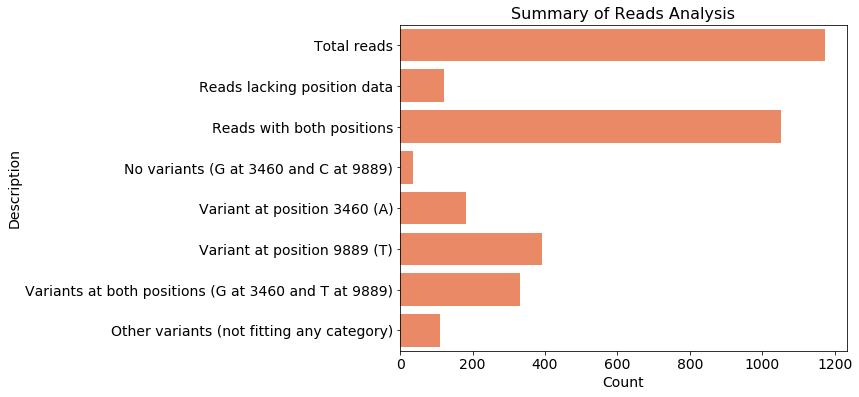

In [101]:
# Ustawienie rozmiaru wykresu
plt.figure(figsize=(8, 6))  # Szerokość, wysokość w calach

# Tworzenie wykresu słupkowego
ax = sns.barplot(data=summary_df, x='Count', y='Description', color='coral')

# Dodawanie opisów osi
ax.set_xlabel('Count', fontsize=14)  # Ustawienie etykiety i rozmiaru czcionki osi X
ax.set_ylabel('Description', fontsize=14)  # Ustawienie etykiety i rozmiaru czcionki osi Y
ax.set_title('Summary of Reads Analysis', fontsize=16)  # Tytuł wykresu
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Zapisywanie wykresu do pliku
plt.savefig('dna_reads_summary.png')  # Zapis do pliku PNG

# Wyświetlenie wykresu
plt.show()

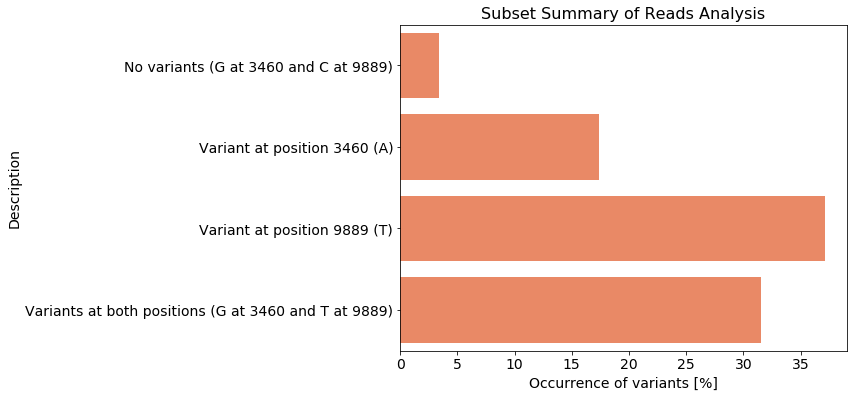

In [110]:
### Wizualizacje tylko dla wariantów


# Wybór wierszy od czwartego do siódmego (indeksy od 3 do 6, ponieważ indeksujemy od 0)
subset_df = summary_df.iloc[3:7]

# Ustawienie rozmiaru wykresu
plt.figure(figsize=(8, 6))  # Szerokość, wysokość w calach

# Tworzenie wykresu słupkowego dla wybranego podzbioru
ax = sns.barplot(data=subset_df, x='Percentage_of_complete_reads', y='Description', color='coral')

# Dodawanie opisów osi z niestandardową czcionką
ax.set_xlabel('Occurrence of variants [%]', fontsize=14)  # Ustawienie etykiety i rozmiaru czcionki osi X
ax.set_ylabel('Description', fontsize=14)  # Ustawienie etykiety i rozmiaru czcionki osi Y
ax.set_title('Subset Summary of Reads Analysis', fontsize=16)  # Tytuł wykresu

# Dostosowanie etykiet na osiach
plt.xticks(fontsize=14)  # Ustawienie rozmiaru czcionki dla etykiet na osi X
plt.yticks(fontsize=14)  # Ustawienie rozmiaru czcionki dla etykiet na osi Y

# Zapisywanie wykresu do pliku
plt.savefig('subset_dna_reads_summary.png', dpi=300)  # Zapis do pliku PNG z wysoką rozdzielczością

# Wyświetlenie wykresu
plt.show()

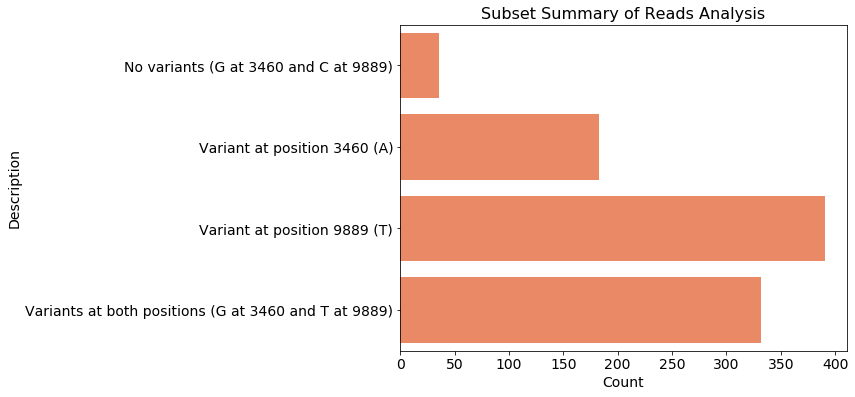

In [109]:
## to samo tylko z wartościami procentowymi:

# Wybór wierszy od czwartego do siódmego (indeksy od 3 do 6, ponieważ indeksujemy od 0)
subset_df = summary_df.iloc[3:7]

# Ustawienie rozmiaru wykresu
plt.figure(figsize=(8, 6))  # Szerokość, wysokość w calach

# Tworzenie wykresu słupkowego dla wybranego podzbioru
ax = sns.barplot(data=subset_df, x='Count', y='Description', color='coral')

# Dodawanie opisów osi z niestandardową czcionką
ax.set_xlabel('Count', fontsize=14)  # Ustawienie etykiety i rozmiaru czcionki osi X
ax.set_ylabel('Description', fontsize=14)  # Ustawienie etykiety i rozmiaru czcionki osi Y
ax.set_title('Subset Summary of Reads Analysis', fontsize=16)  # Tytuł wykresu

# Dostosowanie etykiet na osiach
plt.xticks(fontsize=14)  # Ustawienie rozmiaru czcionki dla etykiet na osi X
plt.yticks(fontsize=14)  # Ustawienie rozmiaru czcionki dla etykiet na osi Y

# Zapisywanie wykresu do pliku
plt.savefig('subset_dna_reads_summary.png', dpi=300)  # Zapis do pliku PNG z wysoką rozdzielczością

# Wyświetlenie wykresu
plt.show()

## Jakie inne nukleotydy znalazły się we wskazanych pozycjach?

In [59]:
# Dodaję kolumnę zawierającą nukleotydy w pozycjach 3460 i 9889

output_raw['3460_9889'] = output_raw['3460'] + '_' + output_raw['9889'] 

In [61]:
# Teraz sprawdzam jaki jest rozklad różnych wariantów. Zgadza się z wcześniejszymi wyliczeniami.

output_raw['3460_9889'].value_counts()

A_T    391
G_T    332
A_C    183
G_C     36
A_A     32
C_T     21
G_A     17
C_C     11
A_D      8
T_T      7
D_T      5
A_G      3
D_G      1
D_C      1
C_A      1
T_C      1
G_D      1
G_G      1
Name: 3460_9889, dtype: int64

## Statystyki

In [111]:
# Dane z eksperymentów

## Test statytyczny dla połączonego eksperymentu 1 i 2

import scipy.stats as stats

# Dane dla eksperymentu 1
data_exp1 = [sam_bez_mutacji_1_2.shape[0],
        sam_mut_1.shape[0],
        sam_mut_2.shape[0],
        sam_mut_1_2.shape[0]]  # no_variants, variant1, variant2, variants1&2

# Obliczenie łącznej liczby obserwacji
total_obs = sum(data_exp1)

# Obliczenie oczekiwanej liczby obserwacji dla każdego wariantu, gdyby były rozłożone równomiernie
expected = [total_obs / 4] * 4  # Zakładamy równe rozłożenie

# Przeprowadzenie testu Chi-kwadrat dobroci dopasowania
chi2_stat, p_value = stats.chisquare(data_exp1, f_exp=expected)

print(f"Chi2 Statystyka = {chi2_stat:.2f}, p-wartość = {p_value}")


Chi2 Statystyka = 322.93, p-wartość = 1.0849442477712621e-69
